In [124]:
import pandas as pd
import numpy as np
import spacy
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [325]:
test = pd.read_csv('./data/testing.csv')

In [319]:
allowed_labels = ['1','2','3','4','5']
# for index, row in test.iterrows():
#     if (str(row['star_rating']).strip() not in allowed_labels) or (len(str(row['review_body']).strip()) < 3):
#         test.drop(index, inplace=True)

In [326]:
model = spacy.load('./models/reviews_1_balanced_full')

In [304]:
def createAnnotation(rating: str):
        annot = {
            'cats':{
                '5' : False,
                '4' : False,
                '3' : False,
                '2' : False,
                '1' : False,
                }
            }
        annot['cats'][rating] = True
        return annot

In [337]:
TEST_DATA = list()
y_ = []
sample_size = len(test)
for index, row in test.sample(n=sample_size).iterrows():
    if (str(row['star_rating']).strip() not in allowed_labels) or (len(str(row['review_body']).strip()) < 3):
      continue
    annotation = createAnnotation(str(row['star_rating']).strip())
    y_.append(row['star_rating'])
    TEST_DATA.append((str(row['review_body']).strip(), annotation))
y_pred = []
y_pred_class = []
for input_, annotations in TEST_DATA:
    pred = model(input_)
    y_pred.append(list(pred.cats.values()))
    y_pred_class.append(int(max(pred.cats, key=pred.cats.get)))

y_pred = np.array(y_pred)
y_true = pd.DataFrame(y_).squeeze()

In [339]:
classes = model.get_pipe('textcat').labels
classes = [int(i) for i in classes]
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])

In [342]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr



In [343]:

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


In [344]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


In [346]:
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(columns=['class', 'proba'])
    df_aux['class'] = [1 if y == c else 0 for y in y_true]
    df_aux['prob'] = y_pred[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

/var/folders/jv/gz_8xs117w34z4zj8kw605000000gn/T/ipykernel_65918/3278011625.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)
/var/folders/jv/gz_8xs117w34z4zj8kw605000000gn/T/ipykernel_65918/3278011625.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)
/var/folders/jv/gz_8xs117w34z4zj8kw605000000gn/T/ipykernel_65918/3278011625.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)


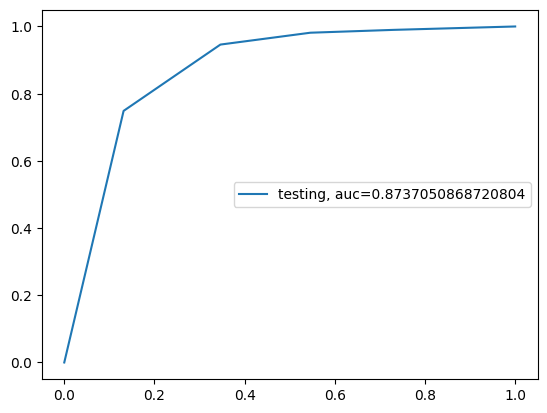

In [ ]:
fpr, tpr, thresholds = roc_curve(y_, y_pred_class, pos_label=5)
area_under_the_curve = auc(fpr, tpr)
plt.plot(fpr,tpr,label="testing, auc="+str(area_under_the_curve))
plt.legend(loc=5)
plt.show()
plt.savefig('./plots/roc.png')

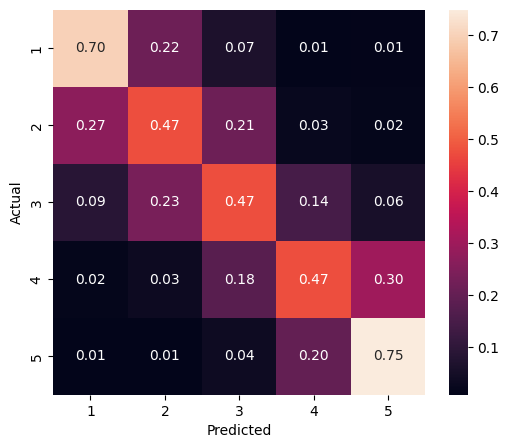

In [333]:
cm = confusion_matrix(y_, y_pred_class)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [340]:
fig.savefig('./plots/confusion_matrix.png')

In [ ]:
test_grouped = test.groupby(['star_rating']).agg({'review_body':'count'}).reset_index()

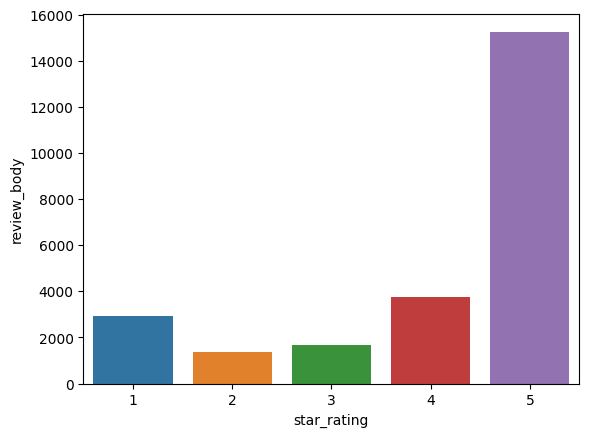

In [ ]:
fig = sns.barplot(data=test_grouped, x='star_rating', y='review_body')
plt.savefig('./plots/barchart.png') 

In [ ]:
bins = [i/20 for i in range(20)] + [1]
sns.histplot(x = "prob", data = test_grouped, hue = 'class', color = 'b', ax = ax, bins = bins)

ValueError: Could not interpret value `prob` for parameter `x`